## This notebook was created in Google Colab using an A100 GPU as it is very resource intensive

In [3]:
!pip install tensorflow

     ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/276.5 MB 3.3 MB/s eta 0:01:24
     ---------------------------------------- 0.2/276.5 MB 3.7 MB/s eta 0:01:14
     ---------------------------------------- 0.7/276.5 MB 5.6 MB/s eta 0:00:50
     ---------------------------------------- 1.2/276.5 MB 6.7 MB/s eta 0:00:42
     ---------------------------------------- 2.1/276.5 MB 9.0 MB/s eta 0:00:31
     --------------------------------------- 3.2/276.5 MB 12.0 MB/s eta 0:00:23
      -------------------------------------- 4.4/276.5 MB 13.2 MB/s eta 0:00:21
      -------------------------------------- 5.1/276.5 MB 14.0 MB/s eta 0:00:20
      -------------------------------------- 6.6/276.5 MB 16.2 MB/s eta 0:00:17
     - ------------------------------------- 7.2/276.5 MB 16.4 MB/s eta 0:00:17
     - ------------------------------------- 7.5/276.5 MB 14.6 MB/s eta 0:00:19
     - ------------------------------------- 7.

In [1]:
# install keras_tunes
!pip install keras-tuner --upgrade

  Using cached keras_tuner-1.3.5-py3-none-any.whl (176 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)


In [4]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#reading in test images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import Image, SVG
from urllib.request import urlopen
from io import BytesIO
from tensorflow.keras.preprocessing import image

import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import keras_tuner

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

#### Mounting google drive in order to read images from kaggle API

In [3]:
#Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#upload kaggle.json
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stanjohn04","key":"2237b724087b8c8518d69b3a547c406b"}'}

In [5]:
#import images from kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale
!unzip 30k-cats-and-dogs-150x150-greyscale.zip

Streaming output truncated to the last 5000 lines.
  inflating: Animal Images/dogs/dog.441.jpg  
  inflating: Animal Images/dogs/dog.4410.jpg  
  inflating: Animal Images/dogs/dog.4411.jpg  
  inflating: Animal Images/dogs/dog.4412.jpg  
  inflating: Animal Images/dogs/dog.4413.jpg  
  inflating: Animal Images/dogs/dog.4414.jpg  
  inflating: Animal Images/dogs/dog.4415.jpg  
  inflating: Animal Images/dogs/dog.4416.jpg  
  inflating: Animal Images/dogs/dog.4417.jpg  
  inflating: Animal Images/dogs/dog.4418.jpg  
  inflating: Animal Images/dogs/dog.4419.jpg  
  inflating: Animal Images/dogs/dog.442.jpg  
  inflating: Animal Images/dogs/dog.4420.jpg  
  inflating: Animal Images/dogs/dog.4421.jpg  
  inflating: Animal Images/dogs/dog.4422.jpg  
  inflating: Animal Images/dogs/dog.4423.jpg  
  inflating: Animal Images/dogs/dog.4424.jpg  
  inflating: Animal Images/dogs/dog.4425.jpg  
  inflating: Animal Images/dogs/dog.4426.jpg  
  inflating: Animal Images/dogs/dog.4427.jpg  
  inflating

### Using ImageDataGenerator to combine cats and dogs folders into one dataset with labels 0:Cat, 1:Dog

In [6]:
# Create an ImageDataGenerator object
train_datagen = ImageDataGenerator(rescale = 1./255)

# Create a flow of images from the folders and set their class labels
train_generator = train_datagen.flow_from_directory(
    directory = 'Animal Images',
    target_size = (150, 150),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = 30000
)

Found 30061 images belonging to 2 classes.


In [7]:
#split data into training and test sets
X, y = train_generator.next()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
print("X_train shape:",X_train.shape)
print("X_val shape:",X_test.shape)
print("Y_train shape:",y_train.shape)
print("Y_val shape:",y_test.shape)

X_train shape: (27000, 150, 150, 1)
X_val shape: (3000, 150, 150, 1)
Y_train shape: (27000,)
Y_val shape: (3000,)


### Experimenting and building our CNN model

In [9]:
#build base model
base_model=Sequential()
base_model.add(Convolution2D(16,3,3,input_shape=(150,150,1),activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(Flatten())
base_model.add(Dense(128,activation='relu'))
base_model.add(Dense(1,activation='sigmoid'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,417
Trainable params: 1,280,417
Non-trainable params: 0
______________________________________________

In [10]:
# compile model
optimizer = Adam(learning_rate=0.001)
base_model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [11]:
# train model
base_model.fit(X_train,y_train, epochs=25,validation_data=(X_test,y_test))

Epoch 1/25
844/844 [==============================] - 17s 6ms/step - loss: 0.6407 - accuracy: 0.6365 - val_loss: 0.6075 - val_accuracy: 0.6750
Epoch 2/25
844/844 [==============================] - 4s 5ms/step - loss: 0.5612 - accuracy: 0.7134 - val_loss: 0.5910 - val_accuracy: 0.6897
Epoch 3/25
844/844 [==============================] - 4s 5ms/step - loss: 0.5166 - accuracy: 0.7425 - val_loss: 0.5789 - val_accuracy: 0.7063
Epoch 4/25
844/844 [==============================] - 4s 5ms/step - loss: 0.4764 - accuracy: 0.7696 - val_loss: 0.5574 - val_accuracy: 0.7140
Epoch 5/25
844/844 [==============================] - 4s 5ms/step - loss: 0.4323 - accuracy: 0.7988 - val_loss: 0.5814 - val_accuracy: 0.7013
Epoch 6/25
844/844 [==============================] - 5s 5ms/step - loss: 0.3847 - accuracy: 0.8247 - val_loss: 0.5855 - val_accuracy: 0.7093
Epoch 7/25
844/844 [==============================] - 4s 5ms/step - loss: 0.3330 - accuracy: 0.8529 - val_loss: 0.6470 - val_accuracy: 0.7080
Epoch

In [12]:
# print model loss and accuracy on test set
# model_loss, model_accuracy = base_model.evaluate(X_test,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [13]:
# model using different activation and more convolution/pooling layers
# added dropout layer
model2 = Sequential()

model2.add(Convolution2D(12, (3,3),activation ='leaky_relu', input_shape = X_train.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Convolution2D(24, (3,3),activation ='leaky_relu'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model2.add(Flatten())
model2.add(Dense(128, activation = "leaky_relu"))
# add dropout layer
model2.add(Dropout(0.1))
model2.add(Dense(1, activation = "sigmoid"))

In [14]:
# compile model
#different learning rates tested 0.1, 0.01, 0.001, 0.0001
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [15]:
# train model
# different batch_sizes were tested: 100,200,250,300
batch_size=200
model2.fit(X_train,y_train,batch_size = batch_size, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
135/135 [==============================] - 5s 19ms/step - loss: 0.7558 - accuracy: 0.5561 - val_loss: 0.6607 - val_accuracy: 0.6127
Epoch 2/20
135/135 [==============================] - 2s 15ms/step - loss: 0.6304 - accuracy: 0.6500 - val_loss: 0.5978 - val_accuracy: 0.6913
Epoch 3/20
135/135 [==============================] - 2s 15ms/step - loss: 0.5752 - accuracy: 0.7029 - val_loss: 0.5714 - val_accuracy: 0.7053
Epoch 4/20
135/135 [==============================] - 2s 15ms/step - loss: 0.5275 - accuracy: 0.7386 - val_loss: 0.5526 - val_accuracy: 0.7200
Epoch 5/20
135/135 [==============================] - 2s 15ms/step - loss: 0.4855 - accuracy: 0.7670 - val_loss: 0.5263 - val_accuracy: 0.7410
Epoch 6/20
135/135 [==============================] - 2s 15ms/step - loss: 0.4438 - accuracy: 0.7934 - val_loss: 0.5474 - val_accuracy: 0.7200
Epoch 7/20
135/135 [==============================] - 2s 15ms/step - loss: 0.4116 - accuracy: 0.8121 - val_loss: 0.5320 - val_accuracy: 0.7407

In [30]:
# print model loss and accuracy
model_loss, model_accuracy = model2.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


94/94 - 0s - loss: 1.1922 - accuracy: 0.7503 - 363ms/epoch - 4ms/step
Loss: 1.192244291305542, Accuracy: 0.750333309173584


### Using Keras-tuner to run trials with different hyperparameters/layers

In [17]:
# params from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range= 0.3,
        zoom_range= 0.3,
        width_shift_range= 0,
        height_shift_range= 0,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train)

In [18]:
# function for keras_tuner
def tuner(hp):
  #set kernel_size and pool_size vairables
  kernel_size = (3,3)
  pool_size = (2,2)
  #set ranges for dropout coefficients
  dropout_coeff_conv = hp.Float("conv_dropout", min_value=0.05, max_value=0.2)
  dropout_coeff_hidden = hp.Float("hidden_dropout", min_value=0.05, max_value=0.2)
  #set ranges for filters, convolutional layers, hidden layers, hidden layer units
  filter_num = hp.Int('filter_num', min_value=2, max_value=24, step=2)
  conv_layer_num =hp.Int('conv_layer', min_value=1, max_value=5, step=1)
  hidden_layer_num = hp.Int('hidden_layer_num', min_value=1, max_value=5, step=1)
  layer_unit = hp.Int('layer_unit',156,1048,100)
  #output and input shapes
  output_num = y_train.shape[0]
  input_shape = X_train.shape[1:]
  #best learning rate from model2
  learning_rate = 0.001

  #build model
  model = Sequential()
  #test different convolutional layers
  for i in range(conv_layer_num):
      model.add(Convolution2D(
          filters=filter_num, kernel_size=kernel_size, padding="same"
          ,activation='relu', input_shape = input_shape))
      filter_num*=2
      model.add(MaxPooling2D(pool_size = pool_size,padding="same"))
      model.add(Dropout(dropout_coeff_conv))

  # test different fully connected layers
  model.add(Flatten())

  print("layer unit(hidden):",layer_unit)
  for i in range(hidden_layer_num):
      model.add(Dense(layer_unit, activation= 'relu'))
      model.add(Dropout(dropout_coeff_hidden))
  model.add(Dense(1,activation='sigmoid'))

  #compile the model
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer,loss = "binary_crossentropy",
              metrics=["accuracy"])
  return model

 #Reduce learning rate when a metric has stopped improving.
 # source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

#Number of trials to run
trial_number = 10

#target validation accuracy
tuner = keras_tuner.RandomSearch(
    tuner,
    objective='val_accuracy',
    max_trials = trial_number,
    overwrite=True,
    project_name="cats_or_dogs_CNN")

tuner.search(datagen.flow(X_train,y_train, batch_size=64).x, datagen.flow(X_train,y_train, batch_size=64).y,
             epochs=10,batch_size = 250, validation_data=(X_test, y_test),callbacks=[reduce_lr])
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.8636666536331177

Best val_accuracy So Far: 0.874666690826416
Total elapsed time: 00h 05m 49s
layer unit(hidden): 456


In [19]:
# Best model from keras_tuner search
# this model summary is from second tuner run and
#isn't as good as first tuner run
# see catDog_model below for best overall model

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 32)        0

### Save models to load into Model_Test.ipynb

In [21]:
#save model to current session and google drive
# FIRST TUNER RUN

# best_model.save('cat_dog_CNN.h5')
# best_model.save('/content/gdrive/MyDrive/cat_or_dog_CNN.keras')

In [29]:
#save model to current session and google drive
# SECOND TUNER RUN

# best_model.save('cat_dog_CNN_2.h5')
# best_model.save('/content/gdrive/MyDrive/cat_or_dog_CNN_2.keras')

In [31]:
# print model loss and accuracy
model_loss, model_accuracy = best_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

94/94 - 1s - loss: 0.2949 - accuracy: 0.8747 - 506ms/epoch - 5ms/step
Loss: 0.2949277460575104, Accuracy: 0.874666690826416


In [22]:
catDog_model = keras.models.load_model('/content/gdrive/MyDrive/cat_or_dog_CNN.keras')

In [32]:
# print model loss and accuracy
# first tuner run is best with 90.87% accuracy on test set
model_loss, model_accuracy = catDog_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

94/94 - 1s - loss: 0.2425 - accuracy: 0.9087 - 741ms/epoch - 8ms/step
Loss: 0.2424721121788025, Accuracy: 0.9086666703224182


In [39]:
catDog_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 16)        0

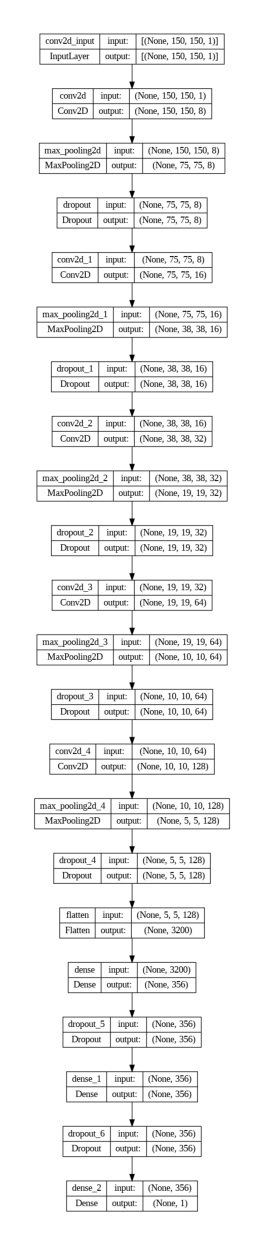

In [38]:
plot_model(catDog_model, to_file='model-diagram.png', show_shapes=True, show_layer_names=True)
plt.figure(dpi=320)
plt.imshow(plt.imread('model-diagram.png'))
plt.axis('off')
plt.show()